# <span style="color:red">Análisis de datos en Python</span>


> Adrián Felipe Hernández Borda
>

>
> Universidad Pedagógica y Tecnológica de Colombia $\Big[\text{UPTC}\Big]$
>
> Universidad Aurónoma de Sinaloa $\Big[\text{UAS}\Big]$
>



El presente es un cuaderno de trabajo, pruebas y avances sobre el proyecto desarrollado en la **optativa de análisis de datos en python**
## <span style="color:rgb(0,180,200)">Objetivos</span>

Entrenar un modelo capaz de predecir las calificaciones de unos estudiantes en pruebas de: (***Matemática, Escritura y Lectura***); con base a algunas características de su entorno académico, familiar y vida personal.

---
# <span style="color:rgb(180,200,0)">Importar librerías</span>

---


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn as sk
sns.set_style(style="ticks")
from os import cpu_count as ncpu
from multiprocessing import Pool as pool
from fitter import Fitter as ftr

import warnings
warnings.filterwarnings('ignore') 

#%matplotlib widget

---
## <span style="color:rgb(180,200,0)">Importar datos</span>

---
Se importa el `csv` con la base de datos con la ruta del archivo.

In [2]:
path = "./datasets/"

file = "Expanded_data_with_more_features.csv"

full_path = path+file

print(f"Dirección del conjunto de datos: '{full_path:s}'")


Dirección del conjunto de datos: './datasets/Expanded_data_with_more_features.csv'


In [3]:
data = pd.read_csv(full_path,sep=",")

data = data.drop(labels='ID',axis=1)
sz = data.shape
print(f"Número de variables -> {sz[0]}\nEntradas del conjunto de datos -> {sz[1]}")

print("\n--- CABECERA DEL CONJUNTO DE DATOS ---\n")
display(data.head())

print("\n--- DESCRIPCIÓN ---\n")
display(data.info())

Número de variables -> 30641
Entradas del conjunto de datos -> 14

--- CABECERA DEL CONJUNTO DE DATOS ---



,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75



--- DESCRIPCIÓN ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  object 
 1   EthnicGroup          28801 non-null  object 
 2   ParentEduc           28796 non-null  object 
 3   LunchType            30641 non-null  object 
 4   TestPrep             28811 non-null  object 
 5   ParentMaritalStatus  29451 non-null  object 
 6   PracticeSport        30010 non-null  object 
 7   IsFirstChild         29737 non-null  object 
 8   NrSiblings           29069 non-null  float64
 9   TransportMeans       27507 non-null  object 
 10  WklyStudyHours       29686 non-null  object 
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(3), object(10)
memory usage: 3.3+ MB


None


# <span style="color:rgb(180,200,0)">Descripción del conjunto de datos</span>


Lo primero que hay que notar es que existen varias clases que tienen `object` como tipo de dato; es decir que son de variables categricas. Adicionalmente, es necesario tratar los datos faltantes `NaN`. Por ahora se revisa si existe filas repetidas

In [4]:
print(f"Hay {data[data.duplicated()].shape} filas duplicadas")

Hay (0, 14) filas duplicadas


## Variables 
Las variables aportan infromación: **personal, académica, familiar, socioeconómica**; de los estudiantes
### Categóricas
1. `Gender`: Género -> personal
2. `EthnicGroup` Etnia -> socioeconómica
3. `ParentMaritalStatus` Estado matrimonial de los padres -> familiar
4. `PracticeSport` Actividad deportiva -> personal
5. `IsFirstChild` Primogenito -> familiar
6. `TransportMeans` Transporte -> socioeconómica


### Ordinales
1. `LunchType` Alimentación -> socioeconómica, personal
2. `TestPrep` Preparación previa  -> personal, académica
3. `ParentEduc` Nivel educativo de los padres -> socioeconómica, personal
4. `WklyStudyHours` Horas de estudio semanal -> personal, académica

### Cuantitativas (Discretas)
1. `ID`identificador  de estudiante -> está incompleto y con datos repetidos, no aporta mucha información
2. `NrSiblings` Número de hermanos -> familiar
3. `MathScore` calificación en matemáticas -> objetivo
4. `ReadingScore` calificación en lectura -> objetivo
5. `WritingScore` calificación en escritura ->


---
# <span style="color:rgb(180,200,0)">Reescritura del conjunto de datos</span>

---
Ahora la meta es tratar los `NaN` de las variables categóricas y ordinales. Primero se marcan las columnas de acuerdo con el tipo de variable:

In [5]:
cols_categoric = ["Gender","EthnicGroup","ParentMaritalStatus","PracticeSport","IsFirstChild","TransportMeans"]
cols_ordinal = ["LunchType","TestPrep","ParentEduc","WklyStudyHours"]
cols_cuantitative = ["NrSiblings","MathScore","ReadingScore","WritingScore"]

# columnas redundantes
cols_binary = ["Gender","IsFirstChild","TransportMeans"]
cols_objective = ["MathScore","ReadingScore","WritingScore"] # objetivo


Para los `NaN`  **categóricos y ordinales** se puede reemplazar por la `moda`, en aras de no introducir nuevos valores o modificar la distribución de la variable.

Para los `NaN` **numéricos**, se puede reemplazar por la `media` o se puede `interpolar`, en este caso se interpolará.

In [6]:
for col in cols_categoric+cols_ordinal:
    data[col] = data[col].fillna(value=data[col].mode()[0]) # llenar con moda

for col in cols_cuantitative:
    data[col] = data[col].interpolate() # llenar con interpolación

Podemos ver los **valores de cada clase** para hacer el mapeo posterior

In [7]:
vals_categoric = []
for k,col in enumerate(data.drop(labels=cols_cuantitative,axis=1).columns.values):
    vals_categoric.append(list(pd.get_dummies(data[[col]],prefix='',prefix_sep='').columns.values))

    print(f"{col} \t tiene {len(list(pd.get_dummies(data[[col]]).columns.values))} valores: \n\t {vals_categoric[k]}")

Gender 	 tiene 2 valores: 
	 ['female', 'male']
EthnicGroup 	 tiene 5 valores: 
	 ['group A', 'group B', 'group C', 'group D', 'group E']
ParentEduc 	 tiene 6 valores: 
	 ["associate's degree", "bachelor's degree", 'high school', "master's degree", 'some college', 'some high school']
LunchType 	 tiene 2 valores: 
	 ['free/reduced', 'standard']
TestPrep 	 tiene 2 valores: 
	 ['completed', 'none']
ParentMaritalStatus 	 tiene 4 valores: 
	 ['divorced', 'married', 'single', 'widowed']
PracticeSport 	 tiene 3 valores: 
	 ['never', 'regularly', 'sometimes']
IsFirstChild 	 tiene 2 valores: 
	 ['no', 'yes']
TransportMeans 	 tiene 2 valores: 
	 ['private', 'school_bus']
WklyStudyHours 	 tiene 3 valores: 
	 ['5 - 10', '< 5', '> 10']


In [8]:
data_tags = data.copy() # esta base de datos tiene las etiquetas sin modificar

In [9]:
dict_gender = {'male':0,'female':1}
dict_parent_educ = {"bachelor's degree": 4, 'some college': 3, "master's degree": 6,
                     "associate's degree": 5, 'high school': 2, 'some high school': 1}
dict_marita = {'divorced':0, 'married':1, 'single':2, 'widowed':3}
dict_sports = {'never':0, 'regularly':1, 'sometimes':2}
dict_study_h = {'5 - 10':1, '< 5':0, '> 10':2}
dict_ethnic = {'group A':0, 'group B':1, 'group C':2, 'group D':3, 'group E':4}
dict_lunch_type = {'standard':1,'free/reduced':0}
dict_test_prep = {'none':0, 'completed':1}
dict_first_child = {'yes':1, 'no':0}
dict_trasport_means = {'school_bus':0, 'private':1}

data['EthnicGroup'] = data['EthnicGroup'].replace(to_replace=dict_ethnic)
data['LunchType'] = data['LunchType'].replace(to_replace=dict_lunch_type)
data['TestPrep'] = data['TestPrep'].replace(to_replace=dict_test_prep)
data['IsFirstChild'] = data['IsFirstChild'].replace(to_replace=dict_first_child)
data['TransportMeans'] = data['TransportMeans'].replace(to_replace=dict_trasport_means)
data['Gender'] = data['Gender'].replace(to_replace=dict_gender)
data['ParentEduc'] = data['ParentEduc'].replace(to_replace=dict_parent_educ)
data['ParentMaritalStatus'] = data['ParentMaritalStatus'].replace(to_replace=dict_marita)
data['PracticeSport'] = data['PracticeSport'].replace(to_replace=dict_sports)
data['WklyStudyHours'] = data['WklyStudyHours'].replace(to_replace=dict_study_h)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gender               30641 non-null  int64  
 1   EthnicGroup          30641 non-null  int64  
 2   ParentEduc           30641 non-null  int64  
 3   LunchType            30641 non-null  int64  
 4   TestPrep             30641 non-null  int64  
 5   ParentMaritalStatus  30641 non-null  int64  
 6   PracticeSport        30641 non-null  int64  
 7   IsFirstChild         30641 non-null  int64  
 8   NrSiblings           30641 non-null  float64
 9   TransportMeans       30641 non-null  int64  
 10  WklyStudyHours       30641 non-null  int64  
 11  MathScore            30641 non-null  int64  
 12  ReadingScore         30641 non-null  int64  
 13  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 3.3 MB


---

# <span style="color:rgb(180,200,0)">Análisis exploratorio</span>

---

## <span style="color:rgb(0,200,200)">Distribución de variables individualmente</span>

para los histogrmas los intervalos se dan por la regla de sturges:
$$N_{\text{bins}} = \text{int}\left(1+\log_{2}(N_{\text{registers}})\right)$$

In [11]:
bins = round(1 + np.log2(data.shape[0]))
print(f"El número de columnas para {data.shape[0]} datos es {bins}.")

El número de columnas para 30641 datos es 16.


### Clases categóricas

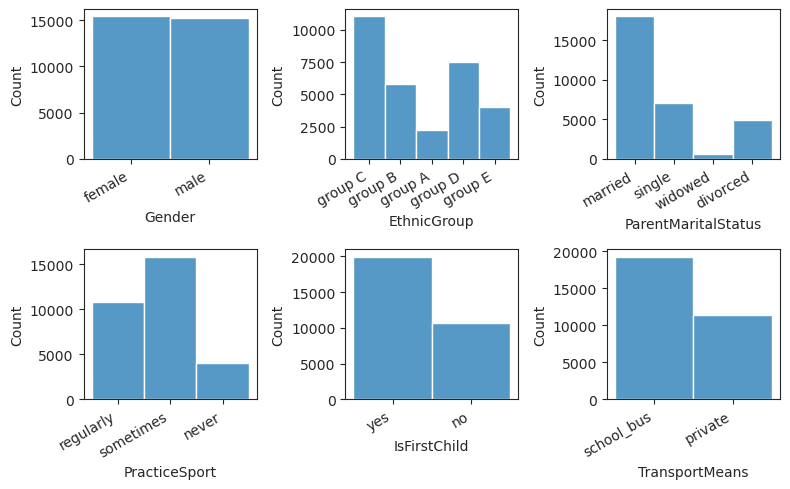

In [12]:
fig,ax = plt.subplots(nrows=2
                      ,ncols=3
                      ,figsize=(8,5))
ax = ax.flatten()
for k,col in enumerate(cols_categoric):
    labels = data_tags[col].unique()
    sns.histplot(data_tags[col],
                 bins=bins
                 ,kde=False
                 ,label=col
                 ,ax=ax[k])
    ax[k].set_xticklabels(labels=labels
                          ,rotation=30
                          ,ha='right')
plt.tight_layout()
plt.show()


### Clases ordinales

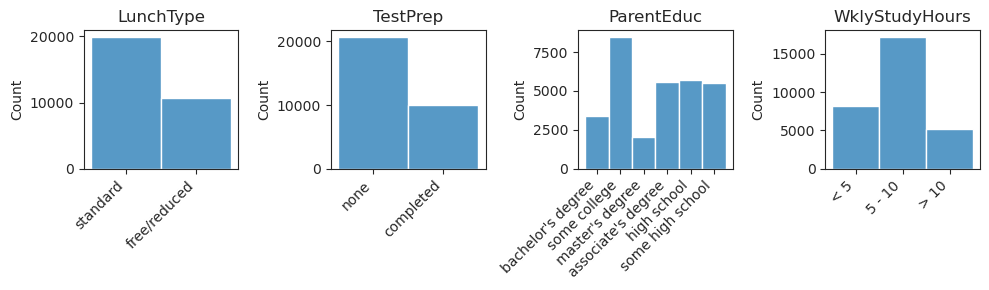

In [13]:
fig,ax = plt.subplots(nrows=1
                      ,ncols=4
                      ,figsize=(10,3))
ax = ax.flatten()
for k,col in enumerate(cols_ordinal):
    label=list(data_tags[col].unique())
    sns.histplot(data_tags[col],
                 bins=bins
                 ,kde=False
                 ,label=col
                 ,ax=ax[k])
    ax[k].xaxis.set_ticklabels(labels=label
                          ,rotation=45
                          , ha='right')
    ax[k].set_xlabel('')
    ax[k].set_title(col)
plt.tight_layout()
plt.show()

### Clases de Objetivo

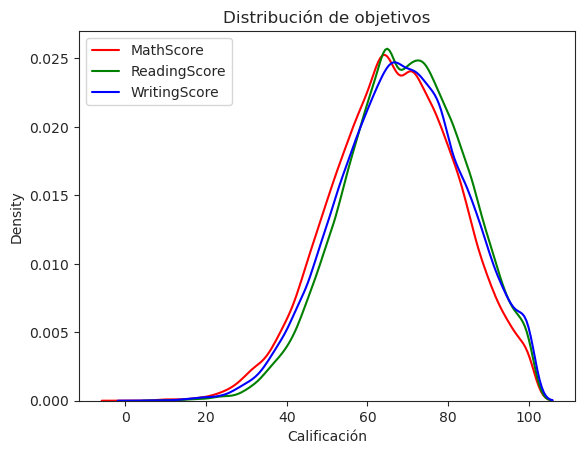

In [14]:
sns.kdeplot(data=data_tags,x='MathScore',label='MathScore',color='red')
sns.kdeplot(data=data_tags,x='ReadingScore',label='ReadingScore',color='green')
sns.kdeplot(data=data_tags,x='WritingScore',label='WritingScore',color='blue')
plt.legend()
plt.title('Distribución de objetivos')
plt.xlabel('Calificación')
plt.show()

Nótese que las clases **categóricas y ordinales se encuentran desbalanceadas**, sin embargo `Gender` es encuentra menos desbalanceada, de manera que resulta práctico usar dicha clase como contraste, tras balancearla con ***SMOTE***. En adición, las calificaciones están correlacionadas, como se muestra en el solapamiento de sus distribuciones, lo que tiene sentido.

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours as ENN
from imblearn.combine import SMOTEENN

In [16]:
def smooting (df_target:pd.DataFrame,df_vars:pd.DataFrame):
    smo = SMOTE(sampling_strategy='not majority',k_neighbors=1,n_jobs=-1)
    enn = ENN(sampling_strategy='not minority',n_neighbors=1)
    method = SMOTEENN(sampling_strategy='auto',n_jobs=-1,smote=smo,enn=enn)
    method.fit(df_vars,df_target)
    df_vars_out, df_target_out = method.fit_resample(df_vars,df_target)
    return df_vars_out, df_target_out

In [17]:
from tqdm import tqdm

In [18]:
def balance(df_main:pd.DataFrame,cols:list):
    df_aux = df_main.copy()
    df_new = df_aux.copy()
    for col in tqdm(cols):
        df_aux = pd.concat(smooting(df_target=df_new[col],
                                    df_vars=df_new.drop(labels=col,axis=1)),axis=1)
        df_new = df_aux.copy()
        del(df_aux)
        print(df_new.shape)
    return df_new

In [19]:
cols_balance = ['EthnicGroup','ParentEduc','LunchType','Gender']

In [20]:
data_nb = balance(df_main=data,cols=cols_balance)

 25%|██▌       | 1/4 [00:02<00:07,  2.35s/it]

(42482, 14)


 50%|█████     | 2/4 [00:04<00:03,  1.97s/it]

(60767, 14)


 75%|███████▌  | 3/4 [00:05<00:01,  1.72s/it]

(61717, 14)


100%|██████████| 4/4 [00:07<00:00,  1.78s/it]

(67615, 14)


Si se elige muchas clases para balancear, la distribución de los objetivos se deteriora bruscamente; adicionalmente el tamaño del conjunto de datos puede crecer en varios órdenes de magnitud, de manera que altera demasiado las predicciones ya que las distribuciones de las demás clases ya balanceadas varían demasiado con respecto a las iniciales. 

In [21]:
data_nb.to_csv(path_or_buf="./data_over_filled.csv",sep=',',index=False)

### Clases categóricas balanceadas

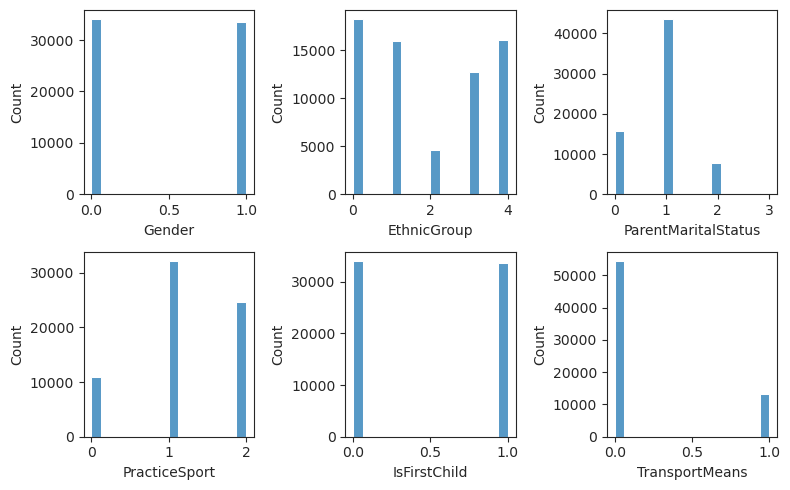

In [23]:
fig,ax = plt.subplots(nrows=2
                      ,ncols=3
                      ,figsize=(8,5))
ax = ax.flatten()
for k,col in enumerate(cols_categoric):
    #labels = data_tags[col].unique()
    sns.histplot(data_nb[col],
                 bins=bins
                 ,kde=False
                 ,label=col
                 ,ax=ax[k])
    #ax[k].set_xticklabels(labels=labels
    #                      ,rotation=30
    #                      ,ha='right')
plt.tight_layout()
plt.show()


### Clases ordinales balanceadas

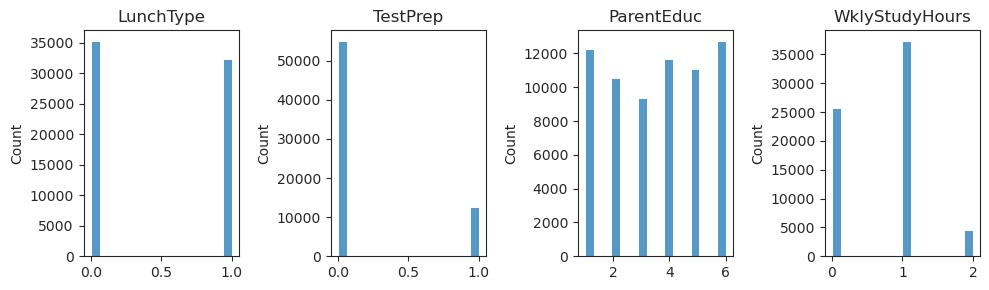

In [24]:
fig,ax = plt.subplots(nrows=1
                      ,ncols=4
                      ,figsize=(10,3))
ax = ax.flatten()
for k,col in enumerate(cols_ordinal):
    label=list(data_tags[col].unique())
    sns.histplot(data_nb[col],
                 bins=bins
                 ,kde=False
                 ,label=col
                 ,ax=ax[k])
    #ax[k].xaxis.set_ticklabels(labels=label
    #                      ,rotation=45
    #                      , ha='right')
    ax[k].set_xlabel('')
    ax[k].set_title(col)
plt.tight_layout()
plt.show()

In [25]:
data_nb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67615 entries, 0 to 67614
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TestPrep             67615 non-null  int64  
 1   ParentMaritalStatus  67615 non-null  int64  
 2   PracticeSport        67615 non-null  int64  
 3   IsFirstChild         67615 non-null  int64  
 4   NrSiblings           67615 non-null  float64
 5   TransportMeans       67615 non-null  int64  
 6   WklyStudyHours       67615 non-null  int64  
 7   MathScore            67615 non-null  int64  
 8   ReadingScore         67615 non-null  int64  
 9   WritingScore         67615 non-null  int64  
 10  EthnicGroup          67615 non-null  int64  
 11  ParentEduc           67615 non-null  int64  
 12  LunchType            67615 non-null  int64  
 13  Gender               67615 non-null  int64  
dtypes: float64(1), int64(13)
memory usage: 7.2 MB


## <span style="color:rgb(0,200,200)">Distribución de objetivos de acuerdo a las demás clases</span>

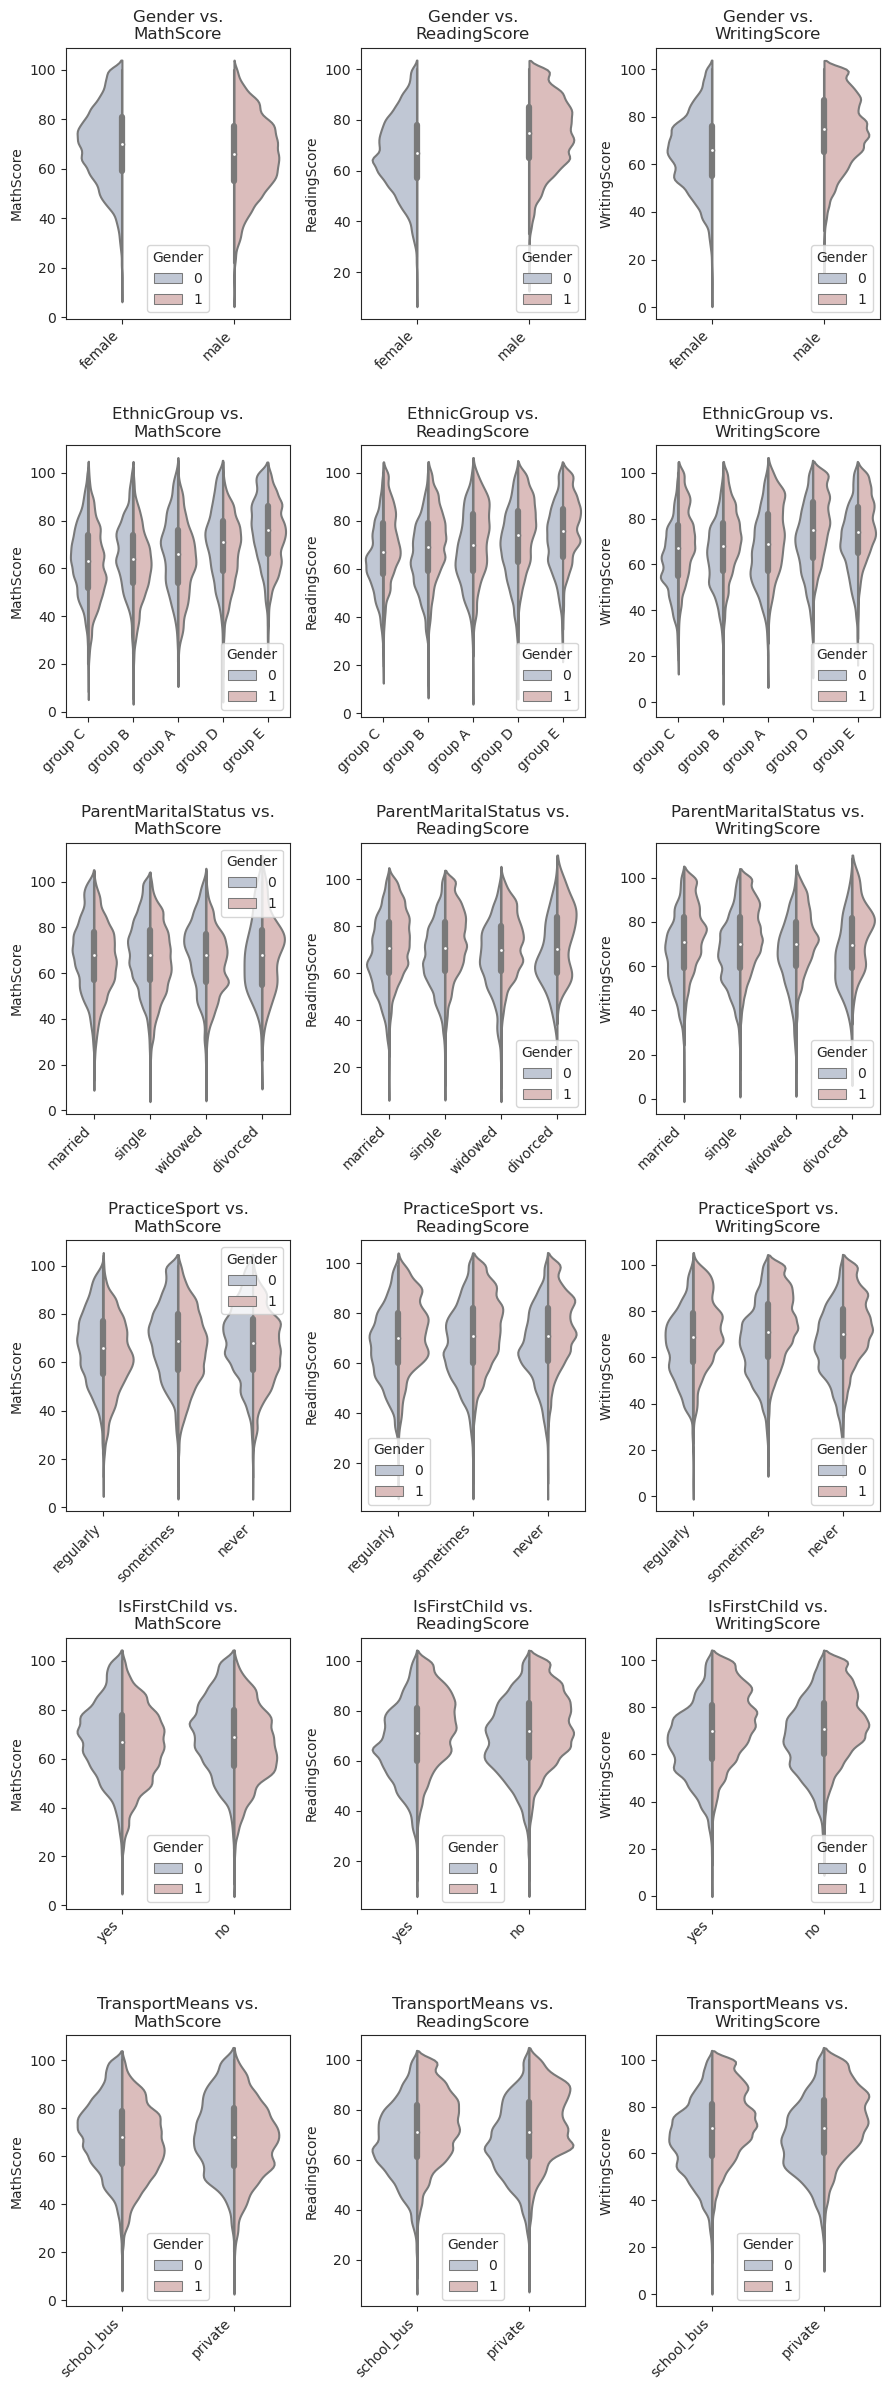

In [26]:
fig, axes = plt.subplots(nrows=6,ncols=3,figsize=(9,24))
for k,col in enumerate(cols_categoric):
    for l in range(3):
        labels = data_tags[col].unique()
        sns.violinplot(data=data_nb,x=col,y=cols_objective[l],hue='Gender',split=True,palette='vlag',ax=axes[k][l])
        axes[k][l].set_title(col+' vs.\n'+cols_objective[l])
        axes[k][l].xaxis.set_ticklabels(labels=labels
                          ,rotation=45
                          , ha='right')
        axes[k][l].set_xlabel('')
fig.set_tight_layout('tight')


### Clases Ordinales

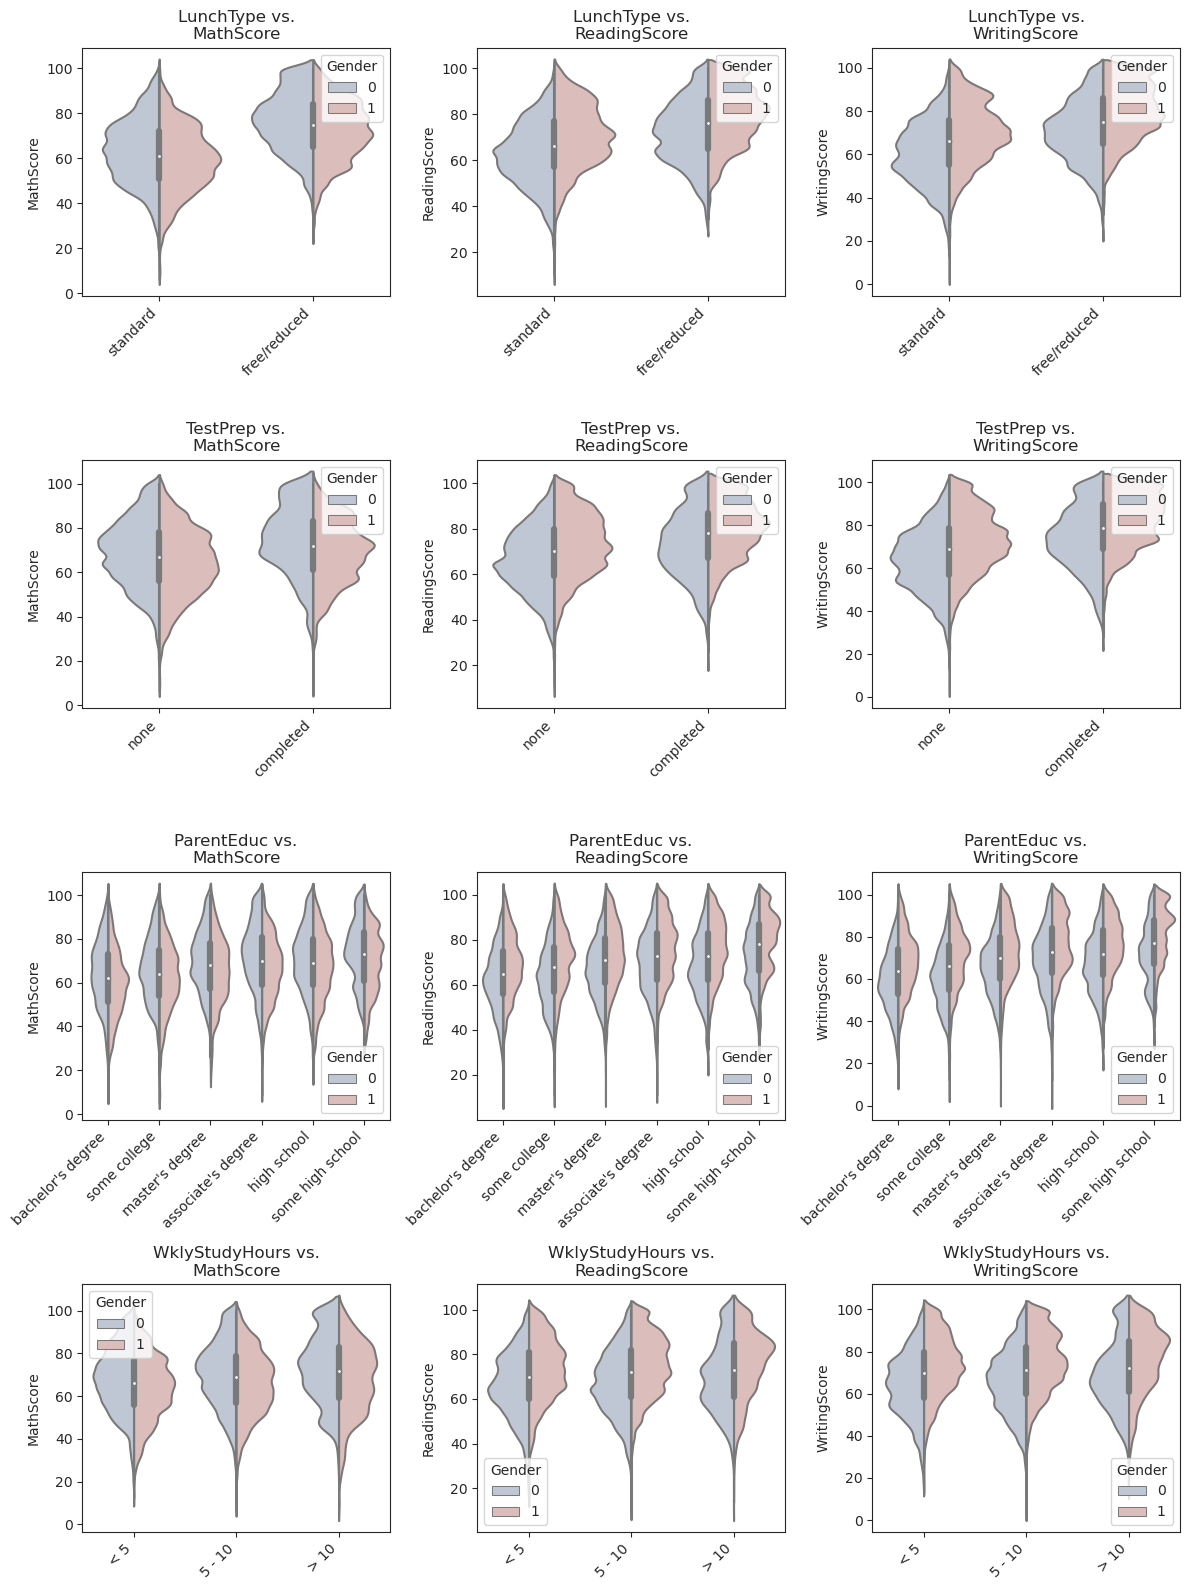

In [27]:
fig, axes = plt.subplots(nrows=4,ncols=3,figsize=(12,16))
for k,col in enumerate(cols_ordinal):
    for l in range(3):
        labels = data_tags[col].unique()
        sns.violinplot(data=data_nb,x=col,y=cols_objective[l],hue='Gender',split=True,palette='vlag',ax=axes[k][l])
        axes[k][l].set_title(col+' vs.\n'+cols_objective[l])
        axes[k][l].xaxis.set_ticklabels(labels=labels
                          ,rotation=45
                          , ha='right')
        axes[k][l].set_xlabel('')
fig.set_tight_layout('tight')

### Clases cuantitativas y objetivos

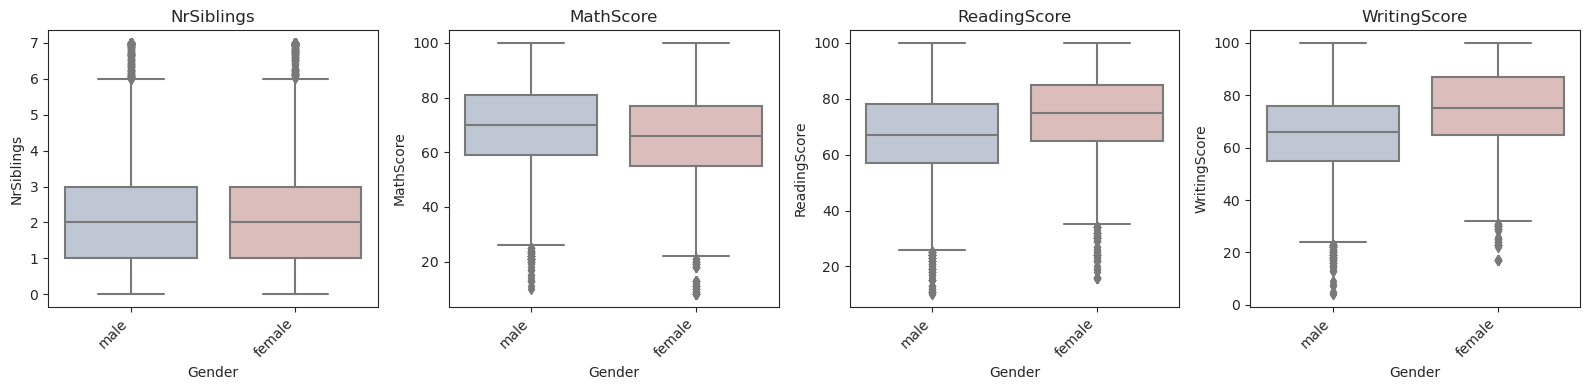

In [28]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(16,4))
ax = ax.flatten()
for k,col in enumerate(cols_cuantitative):
    labels = ['male','female']
    sns.boxplot(data_nb,y=col,x='Gender',ax=ax[k],palette='vlag')
    ax[k].set_title(col)
    ax[k].xaxis.set_ticklabels(labels=labels
                                    ,rotation=45
                                    , ha='right')
plt.tight_layout()


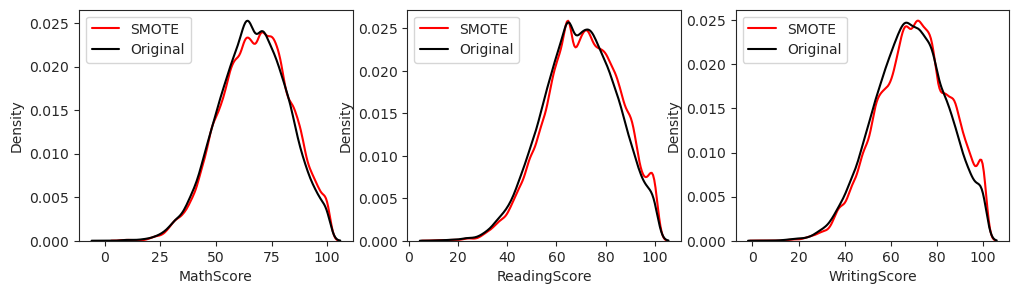

In [29]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
sns.kdeplot(data=data_nb,x='MathScore',label='SMOTE',color='red')
sns.kdeplot(data=data_tags,x='MathScore',label='Original',color='black')

plt.legend()

plt.subplot(1,3,2)
sns.kdeplot(data=data_nb,x='ReadingScore',label='SMOTE',color='red')
sns.kdeplot(data=data_tags,x='ReadingScore',label='Original',color='black')

plt.legend()

plt.subplot(1,3,3)
sns.kdeplot(data=data_nb,x='WritingScore',label='SMOTE',color='red')
sns.kdeplot(data=data_tags,x='WritingScore',label='Original',color='black')

plt.legend()

## Análisis

El patrón común de todas las clases es que: el valor más probables de calificaciones en `MathScore` es superior para el género `male`; por el contrario, la moda de calificaciones de los objetivos `ReadingScore` y `WritingScore`  son superiores para el género `female`.

En las clases socioeconómicas `ParentEduc` y `LunchType`, la moda de calificaciones en los 3 objetivos es más altas en los valores `master's_degree` y `standard`, respectivamente, sin importar el género. Por otro lado, la  clase académica `TestPrep` muestra el mismo comportamiento en el valor `completed`; mientras que, la clase `WklyStudyHours` parece no mostrar un incremento o decremento significativo en las calificaciones objetivo.

La media de calificaciones del los alumnos pertenecientes al grupo étnico `group E` son superiores a las calificaciones de los perteneicentes a otros grupos étnicos.

Lo anterior plantea la interrogante: ¿el comportamiento de los objetivos varía conforme se balancea las características mencionadas, ó no?

## <span style="color:rgb(0,200,200)">Correlación de los datos</span>

In [30]:
def corr_matrix (df:pd.DataFrame):
    fig,axes = plt.subplots(ncols=1,nrows=1,figsize=(20,10))
    
    corr = df.corr()
    sns.heatmap(data=corr,
                annot=True,
                fmt=".2f",
                annot_kws={"fontsize":10},
                cbar=True,
                cmap="vlag",
                linewidth=.5)
    plt.title("Matriz de Correlación")
    plt.show()

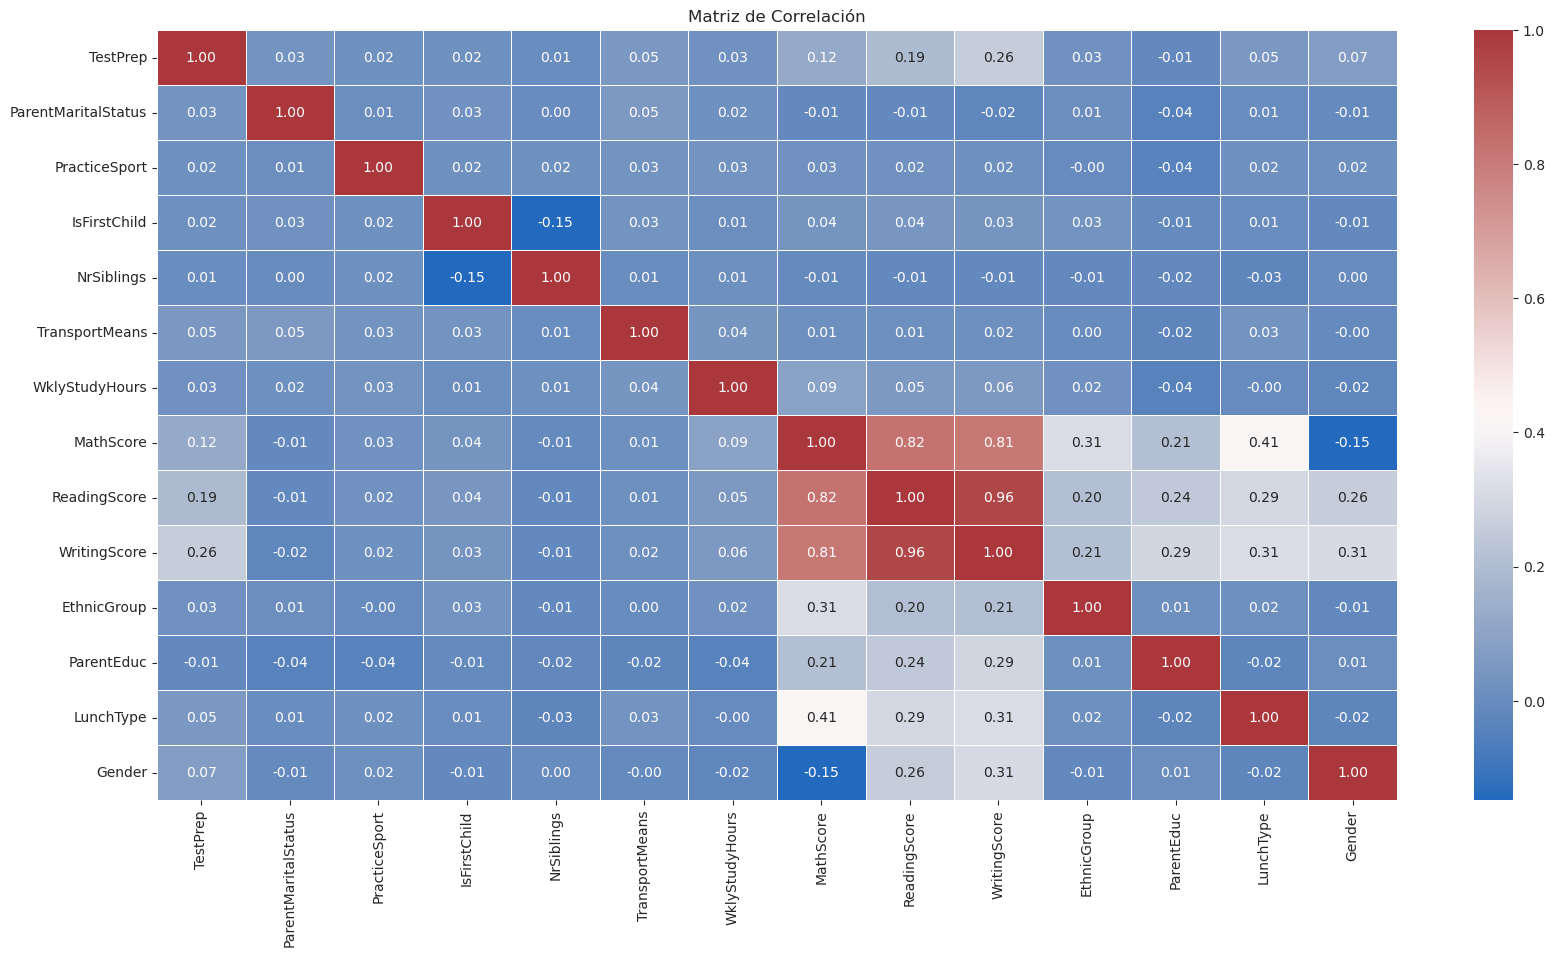

In [31]:
corr_matrix(data_nb)

De acuerdo a la matriz de correlación se puede notar que las clases más correlacioadas con los objetivos son:
1. `MathScore` -> `'LunchType','EthnicGroup','ParentEduc','TestPrep','Gender'`
2. `ReadingScore` -> `'LunchType','Gender','ParentEduc','TestPrep','EthnicGroup'`
3. `WritingScore` -> `'Gender','TestPrep','LunchType','ParentEduc','EthnicGroup'`

---
# <span style="color:rgb(180,200,0)">Selección de variables</span>

---

## <span style="color:rgb(0,200,200)">Con Scikit-Learn</span>

### importar los módulos de selección

se usará la métrica de $\chi^{2}$, Fisher para seleccionar las variables que más influyen se relacionan con el objetivo (las calificaciones)

In [32]:
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.feature_selection import RFE # recursive feature elimination
from sklearn.ensemble import ExtraTreesClassifier,ExtraTreesRegressor 
n_classes=2

In [33]:
target = data[cols_objective]
variables = data.drop(cols_objective,axis=1)

## <span style="color:rgb(200,0,0)"> Select Kbest </span>

In [34]:
def clasif_kbest (df_target,df_train,crit,n_classes):
  df_target = pd.DataFrame(df_target)
  target_name = df_target.columns.values[0]
  df_train =pd.DataFrame(df_train)
  x,y = [np.array(df_train),(np.array(df_target.values.ravel()))]
  result = list()
  for method in crit:
    selector = SelectKBest(score_func=method,k=n_classes)
    atributes = selector.fit(x,y).get_support()
    atributos = [data.drop(cols_objective,axis=1).columns.values[i] for i in list(atributes.nonzero()[0])]
    result.append(atributos)
  result = np.array(result).flatten()
  result = pd.DataFrame({target_name:list(result)}).drop_duplicates()
  return list(np.array(result).flatten())


In [35]:
crit = [f_classif,chi2]
var_selected_kbest = list(range(3))
for k,targ in enumerate(cols_objective):
    var_selected_kbest[k] = clasif_kbest(target[targ],variables,crit=crit,n_classes=n_classes)
display(var_selected_kbest)

[['EthnicGroup', 'LunchType'],
 ['Gender', 'LunchType', 'TestPrep'],
 ['Gender', 'TestPrep']]

In [36]:
def clasif_trees (df_target,df_train,crit,n_classes):
  df_target = pd.DataFrame(df_target)
  target_name = df_target.columns.values[0]
  df_train =pd.DataFrame(df_train)
  x,y = [np.array(df_train),(np.array(df_target.values.ravel()))]
  result = list()
  for method in crit:
    model = ExtraTreesRegressor(criterion=method,n_jobs=ncpu())
    selector = RFE(estimator=model,n_features_to_select=n_classes)
    atributes = selector.fit(x,y).get_support()
    atributos = [variables.columns.values[i] for i in list(atributes.nonzero()[0])]
    result.append(atributos)
  result = np.array(result).flatten()
  result = pd.DataFrame({target_name:list(result)}).drop_duplicates()
  return list(np.array(result).flatten())

In [37]:
crit = ['gini']
crit = ['poisson']
var_selected_trees = [0,0,0]
for k,targ in enumerate(cols_objective):
    var_selected_trees[k] = clasif_trees(target[targ],variables,crit=crit,n_classes=n_classes)
display(var_selected_trees)

[['EthnicGroup', 'LunchType'], ['Gender', 'LunchType'], ['Gender', 'TestPrep']]

In [38]:
def del_dup (df):
    aux = 'name'
    aux = pd.DataFrame({aux:list(df)}).drop_duplicates()
    return np.array(aux)

In [39]:
cols_selected=r_math,r_read,r_writ = [np.array(del_dup(var_selected_trees[k]+var_selected_kbest[k])).flatten() for k in range(3)]

In [40]:
cols_selected


[array(['EthnicGroup', 'LunchType'], dtype=object),
 array(['Gender', 'LunchType', 'TestPrep'], dtype=object),
 array(['Gender', 'TestPrep'], dtype=object)]

En ese sentido vamos a ver la correlación de las variables con lo que se busca predecir

In [41]:
cols_selected_list = list()
for k in range(3):
    for col in cols_selected[k]:
        cols_selected_list.append(col)
cols_selected_list = list(del_dup(cols_selected_list).flatten())
print(f"clases seleccionadas {cols_selected_list}")

clases seleccionadas ['EthnicGroup', 'LunchType', 'Gender', 'TestPrep']


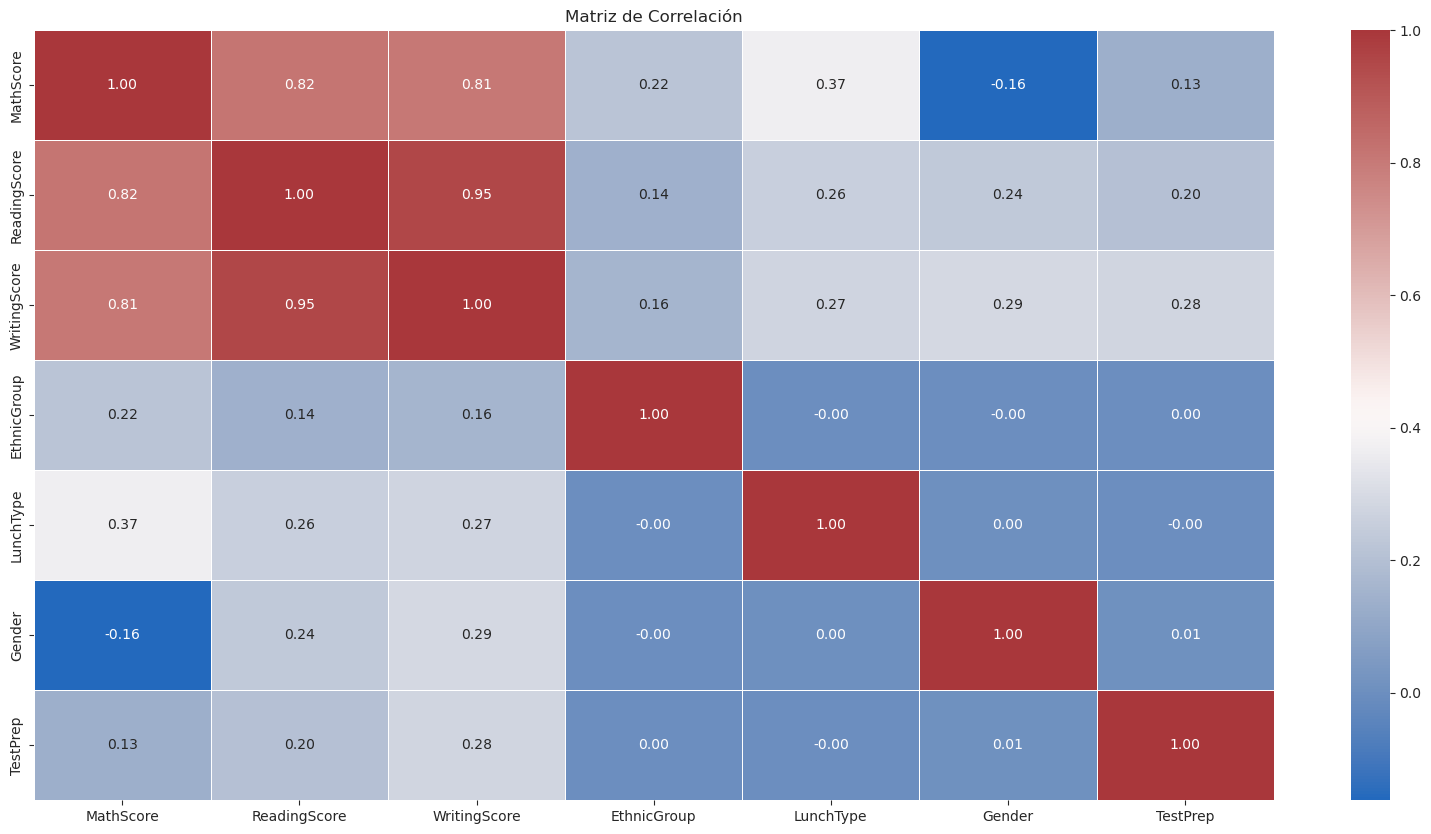

In [42]:

data_selected = data[list(cols_objective + cols_selected_list)]
corr_matrix(data_selected)
plt.show()

# <span style="color:rgb(180,200,0)">Implementación de modelos </span>

## Separar conjunto de variables relevantes

las variables relevantes que influyen en las características de las 3 calificaciones son:

`'LunchType', 'EthnicGroup', 'Gender', 'TestPrep'`

In [94]:
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score

### Separar dataset

In [72]:
bins = round(1+np.log2(data.shape[0]))

x = np.array(data_nb[cols_selected_list])
#x = data_nb.drop(cols_objective,axis=1)

#y = np.array(data_nb['MathScore']).reshape(-1,1)
y = np.array(data_nb[cols_objective])

x_train,x_test,y_train,y_test = split(x,y,train_size=.7)
y_train = y_train.transpose()
y_test = y_test.transpose()

#y1,y2,y3 = np.array(data_nb['MathScore']).reshape(-1,1),np.array(data_nb['ReadingScore']).reshape(-1,1),np.array(data_nb['WritingScore']).reshape(-1,1)

## Regresión lineal

In [73]:
from sklearn.linear_model import LinearRegression

In [112]:
linear_scores = list()
y_predicted = []
for k,col in enumerate(cols_objective):
    y_tr = y_train[k]
    y_te = y_test[k]
    
    regresor = LinearRegression(n_jobs=-1)
    result = regresor.fit(x_train,y_tr)
    y_predicted.append(result.predict(x_test))
    y_pre = y_predicted[k]
    y_tr_pre = regresor.predict(x_train)
    
    print(f"\n--- {col} ---\n")

    metrics = [r2_score(y_tr,y_tr_pred),
               r2_score(y_true=y_te,y_pred=y_predicted[k]),
               mean_squared_error(y_true=y_te,y_pred=y_predicted[k]),
               mean_absolute_error(y_true=y_te,y_pred=y_predicted[k])]
    print(f"r2 entreno = {metrics[0]}")
    print(f"r2 prueba= {metrics[1]}")
    print(f"mse prueba = {metrics[2]}")
    print(f"mae prueba = {metrics[3]}")
    linear_scores.append({col:metrics})


--- MathScore ---

r2 entreno = 0.003353146133664664
r2 prueba= 0.2954033251180834
mse prueba = 172.8350209920778
mae prueba = 10.671392546343059

--- ReadingScore ---

r2 entreno = 0.20464619985303245
r2 prueba= 0.2236784857650309
mse prueba = 171.55374311670258
mae prueba = 10.645513425291801

--- WritingScore ---

r2 entreno = 0.2868042068745408
r2 prueba= 0.2878101389714558
mse prueba = 175.78668239020584
mae prueba = 10.79506329545158


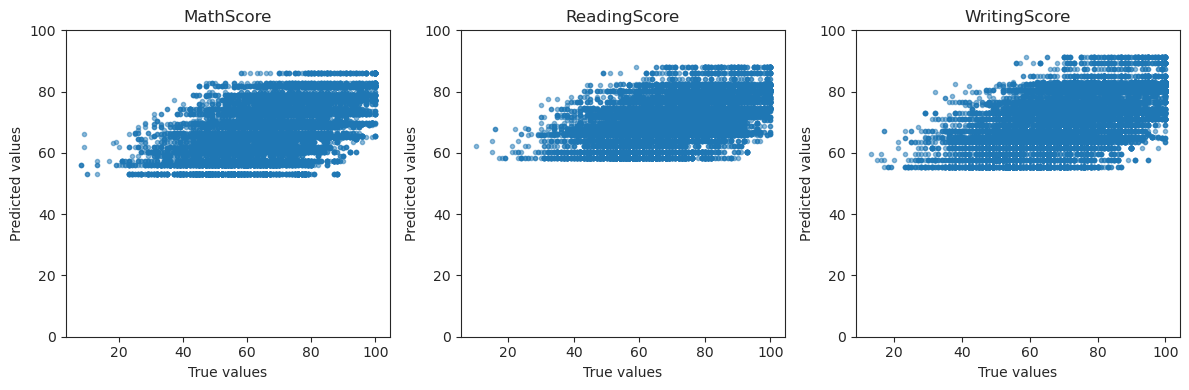

In [101]:
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(12,4))
axs = axs.flatten()
for k,col in enumerate(cols_objective):
    axs[k].scatter(y_test[k],y_predicted[k],alpha=.5,marker='.')
    axs[k].set_title(col)
    axs[k].set_ylim([0,100])
    axs[k].set_xlabel("True values")
    axs[k].set_ylabel("Predicted values")
fig.set_tight_layout(tight=True)

La mayor precisión la alcanzó `MathScore` con $r^2\approx0.295$

La menor precisión fue de `ReadingScore` con $r^2\approx0.224$

## K-vecinos

In [80]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [109]:
n_neighbors = 100

linear_scores = list()
y_predicted = []
for k,col in enumerate(cols_objective):
    y_tr = y_train[k]
    y_te = y_test[k]
    
    print(f"\n--- {col} ---")

    for i,weights in enumerate(['uniform','distance']):
        knn = KNeighborsRegressor(n_neighbors=n_neighbors,weights=weights,n_jobs=-1)
        knn.fit(x_train,y_tr)
        y_predicted.append(result.predict(x_test))
        y_tr_pred = knn.predict(x_train)

        print(f"\nprecisión en entreno {knn.score(x_train,y_tr):1.3f}")
        print(f"precisión en prueba {knn.score(x_test,y_te):1.3f}\n")
        
        metrics = [r2_score(y_tr,y_tr_pred),
                   r2_score(y_true=y_te,y_pred=y_predicted[k]),
                   mean_squared_error(y_true=y_te,y_pred=y_predicted[k]),
                   mean_absolute_error(y_true=y_te,y_pred=y_predicted[k])]
        print(f"r2 entreno = {metrics[0]}")
        print(f"r2 prueba= {metrics[1]}")
        print(f"mse prueba = {metrics[2]}")
        print(f"mae prueba = {metrics[3]}")
        linear_scores.append({col:metrics})


--- MathScore ---

precisión en entreno 0.300
precisión en prueba 0.304

r2 entreno = 0.2995765157331993
r2 prueba= 0.025041397534331544
mse prueba = 239.1538259129604
mae prueba = 12.473475734743923

precisión en entreno 0.300
precisión en prueba 0.304

r2 entreno = 0.2995765157331993
r2 prueba= 0.025041397534331544
mse prueba = 239.1538259129604
mae prueba = 12.473475734743923

--- ReadingScore ---

precisión en entreno 0.218
precisión en prueba 0.220

r2 entreno = 0.2181519278685764
r2 prueba= 0.21184017241206732
mse prueba = 174.16980737699905
mae prueba = 10.685949967808236

precisión en entreno 0.218
precisión en prueba 0.220

r2 entreno = 0.2181519278685764
r2 prueba= 0.21184017241206732
mse prueba = 174.16980737699905
mae prueba = 10.685949967808236

--- WritingScore ---

precisión en entreno 0.287
precisión en prueba 0.286

r2 entreno = 0.2868042068745408
r2 prueba= 0.2878101389714558
mse prueba = 175.78668239020584
mae prueba = 10.79506329545158

precisión en entreno 0.287
p

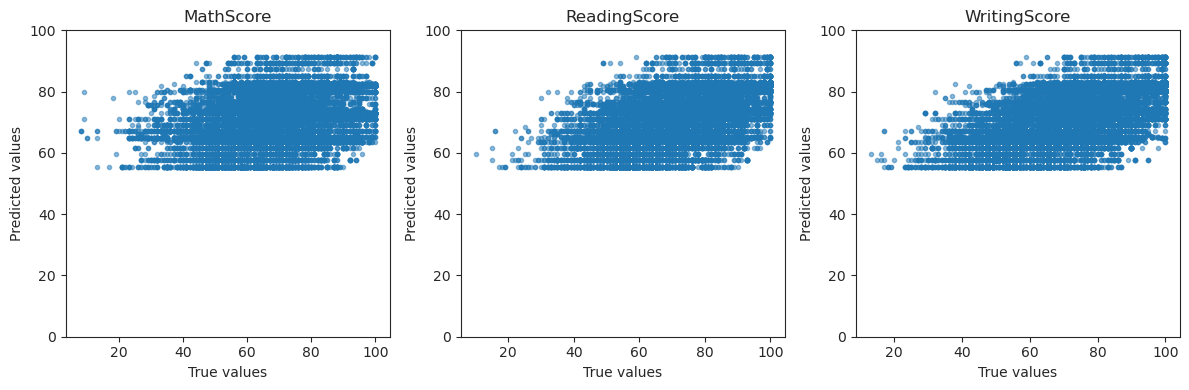

In [110]:
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(12,4))
axs = axs.flatten()
for k,col in enumerate(cols_objective):
    axs[k].scatter(y_test[k],y_predicted[k],alpha=.5,marker='.')
    axs[k].set_title(col)
    axs[k].set_ylim([0,100])
    axs[k].set_xlabel("True values")
    axs[k].set_ylabel("Predicted values")
fig.set_tight_layout(tight=True)

La mayor precisión la alcanzó `WritingScore` con $r^2\approx0.288$

La menor precisión fue de `MathScore` con $r^2\approx0.025$

## Árboles de decisión

In [103]:
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [113]:
linear_scores = list()
y_predicted = []
for k,col in enumerate(cols_objective):
    y_tr = y_train[k]
    y_te = y_test[k]
    
    clf = DecisionTreeRegressor(random_state=42)
    param_grid = {'criterion': ['poisson'], 'max_depth': [10]}
    grid_search = GridSearchCV(clf, param_grid=param_grid, cv=10, return_train_score=True, n_jobs=-1)
    grid_search.fit(x_train, y_tr)

    print(f"\n--- {col} ---\n")

    print(f"Mejores hiperparámetros encontrados: {grid_search.best_params_}")
    print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_}\n")

    best_clf = grid_search.best_estimator_
    y_tr_pred = best_clf.predict(x_train)
    
    y_pre = best_clf.predict(x_test)
    y_predicted.append(result.predict(x_test))

    metrics = [r2_score(y_tr,y_tr_pred),
               r2_score(y_true=y_te,y_pred=y_predicted[k]),
               mean_squared_error(y_true=y_te,y_pred=y_predicted[k]),
               mean_absolute_error(y_true=y_te,y_pred=y_predicted[k])]
    print(f"r2 entreno = {metrics[0]}")
    print(f"r2 prueba= {metrics[1]}")
    print(f"mse prueba = {metrics[2]}")
    print(f"mae prueba = {metrics[3]}")
    linear_scores.append({col:metrics})


--- MathScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.30297996532631216

r2 entreno = 0.3044440698550477
r2 prueba= 0.025041397534331544
mse prueba = 239.1538259129604
mae prueba = 12.473475734743923

--- ReadingScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.22277733856483942

r2 entreno = 0.2245427370168669
r2 prueba= 0.21184017241206732
mse prueba = 174.16980737699905
mae prueba = 10.685949967808236

--- WritingScore ---

Mejores hiperparámetros encontrados: {'criterion': 'poisson', 'max_depth': 10}
Mejor puntuación de validación cruzada: 0.2907570638648276

r2 entreno = 0.2923139018320975
r2 prueba= 0.2878101389714558
mse prueba = 175.78668239020584
mae prueba = 10.79506329545158


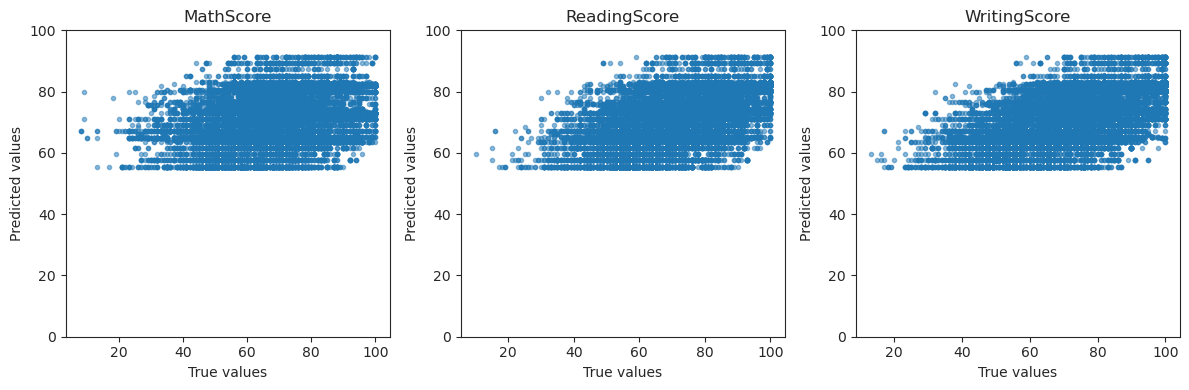

In [114]:
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(12,4))
axs = axs.flatten()
for k,col in enumerate(cols_objective):
    axs[k].scatter(y_test[k],y_predicted[k],alpha=.5,marker='.')
    axs[k].set_title(col)
    axs[k].set_ylim([0,100])
    axs[k].set_xlabel("True values")
    axs[k].set_ylabel("Predicted values")
fig.set_tight_layout(tight=True)

La mayor precisión la alcanzó `WritingScore` con $r^2\approx0.288$

La menor precisión fue de `MathScore` con $r^2\approx0.025$

---
### con los demás métodos (SVM, Neural Networks) el computador se quedó sin memoria ram o duró mucho tiempo (horas) sin respuesta

---